In [1]:
""" Genetic Algorithm Implementation

              Start
                |
                v
        Initialize Population
                |
                v
          Fitness Function
                |
                v
            Selection
                |
                v
            Crossover
                |
                v
             Mutation
                |
                v
           Replacement
                |
                v
          Termination Check -----> No -----> Fitness Function Repeat
                |              
                | Yes          
                |              
                v         
               End

"""

' Genetic Algorithm Implementation\n\n              Start\n                |\n                v\n        Initialize Population\n                |\n                v\n          Fitness Function\n                |\n                v\n            Selection\n                |\n                v\n            Crossover\n                |\n                v\n             Mutation\n                |\n                v\n           Replacement\n                |\n                v\n          Termination Check -----> No -----> Fitness Function Repeat\n                |              \n                | Yes          \n                |              \n                v         \n               End\n\n'

In [2]:
import operator
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

NUMBER_OF_QUEENS = 8
POP_SIZE = 50
ELITE_SIZE = 20
MUTATION_RATE = 0.01
GENERATIONS = 100

## Fitness Function

In [3]:
class Fitness:
    def __init__(self, queen_placements):
        self.queen_placements = queen_placements
        self.number_of_opposing_queens = 0
        self.fitness = 0.0

    def opposing_queens(self):
        if self.number_of_opposing_queens == 0:
            n_opposing_queens = 0
            for index_a, queen_a in enumerate(self.queen_placements):
                for index_b, queen_b in enumerate(self.queen_placements):
                    if queen_a != queen_b:
                        if abs(index_a - index_b) == abs( queen_a.position - queen_b.position):
                            n_opposing_queens += 1
            self.number_of_opposing_queens = n_opposing_queens

        return self.number_of_opposing_queens

    def placement_fitness(self):
        if self.fitness == 0:
            self.fitness = 1 / (1 + float(self.opposing_queens()))
        return self.fitness


def rank_placements(population):
    fitness_results = {}
    for i in range(0, len(population)):
        fitness_results[i] = Fitness(population[i]).placement_fitness()

    return sorted(fitness_results.items(), key=operator.itemgetter(1), reverse=True)


## Plotting Queen Positions

In [4]:
def plot(positions):
    board = np.zeros((NUMBER_OF_QUEENS, NUMBER_OF_QUEENS, 3))
    board += 0.5
    board[::2, ::2] = 1
    board[1::2, 1::2] = 1

    positions = [x - 1 for x in positions]

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(board, interpolation="nearest")

    queen = plt.imread("queen.png")
    extent = np.array([-0.4, 0.4, -0.4, 0.4])
    for y, x in enumerate(positions):
        ax.imshow(queen, extent=extent + [x, x, y, y])

    ax.set(xticks=[], yticks=[])
    ax.axis("image")

    plt.show()

## Initial Population

In [5]:
class Queen:
    def __init__(self, position):
        self.position = position

    def __repr__(self):
        return "(" + str(self.position) + ")"
    

def create_placements(queen_list):
    placement = random.sample(queen_list, len(queen_list))
    return placement


def initial_population(pop_size, queen_list):
    population = []

    for i in range(0, pop_size):
        population.append(create_placements(queen_list))
    return population

## Selection using Roulette Wheel

In [6]:
def selection(pop_ranked, elite_size):
    selection_results = []
    
    df = pd.DataFrame(np.array(pop_ranked), columns=["Index", "Fitness"])
    df["cummulative_sum"] = df.Fitness.cumsum()
    df["cummulative_percentage"] = 100 * df.cummulative_sum / df.Fitness.sum()
    
    # elite selection
    for i in range(0, elite_size):
        selection_results.append(pop_ranked[i][0])
    
    # roulette wheel selection
    for i in range(0, len(pop_ranked) - elite_size): 
        pick = 100 * random.random()
        for i in range(0, len(pop_ranked)):
            if pick <= df.iat[i, 3]:
                selection_results.append(pop_ranked[i][0])
                break
    
    return selection_results

## Extracting Parent Chromosomes

In [7]:
def parents(population, selection_results):
    parents = []
    for i in range(0, len(selection_results)):
        index = selection_results[i]
        parents.append(population[index])
    return parents

## Crossover using Ordered Crossover

In [8]:
"""
Ordered Crossover Demonstration:
parent_1 = [1, 2, 3, 4, 5, 6, 7, 8]
parent_2 = [8, 7, 6, 5, 4, 3, 2, 1]

gene_a = 3
gene_b = 6

child_p1 = [4, 5, 6]
child_p2 = [8, 7, 3, 2, 1]

child = [4, 5, 6, 8, 7, 3, 2, 1]
"""

def breed(parent_1, parent_2):
    child = []
    child_p1 = []
    child_p2 = []

    gene_a = int(random.random() * len(parent_1))
    gene_b = int(random.random() * len(parent_1))

    start_gene = min(gene_a, gene_b)
    end_gene = max(gene_a, gene_b)

    for i in range(start_gene, end_gene):
        child_p1.append(parent_1[i])

    child_p2 = [item for item in parent_2 if item not in child_p1]

    child = child_p1 + child_p2
    return child

def breed_population(parents, elite_size):
    children = []
    length = len(parents) - elite_size
    pool = random.sample(parents, len(parents))

    for i in range(0, elite_size):
        children.append(parents[i])

    for i in range(0, length):
        child = breed(pool[i], pool[len(parents) - i - 1])
        children.append(child)
    return children

## Mutation using Swap Mutation

In [9]:
def mutate(individual, mutation_rate):
    for swapped in range(len(individual)):
        
        if random.random() < mutation_rate:
            swap_with = int(random.random() * len(individual))
            individual[swapped], individual[swap_with] = individual[swap_with], individual[swapped]

    return individual

def mutate_population(population, mutation_rate):
    mutated_pop = []

    for ind in range(0, len(population)):
        mutated_ind = mutate(population[ind], mutation_rate)
        mutated_pop.append(mutated_ind)
    return mutated_pop


## Evolving Population for Generations

In [10]:
def next_generation(current_gen, elite_size, mutation_rate):
    pop_ranked = rank_placements(current_gen)
    selection_results = selection(pop_ranked, elite_size)
    parent = parents(current_gen, selection_results)
    children = breed_population(parent, elite_size)
    next_generation = mutate_population(children, mutation_rate)
    return next_generation

## Genatic Algorithm

In [11]:
def genetic_algorithm(population, pop_size, elite_size, mutation_rate, generations):
    pop = initial_population(pop_size, population)

    for i in range(0, generations):
        pop = next_generation(pop, elite_size, mutation_rate)

    best_placement_index = rank_placements(pop)[0][0]

    best_placement = pop[best_placement_index]
    return best_placement

## Main Function

Initial Queen Placements:


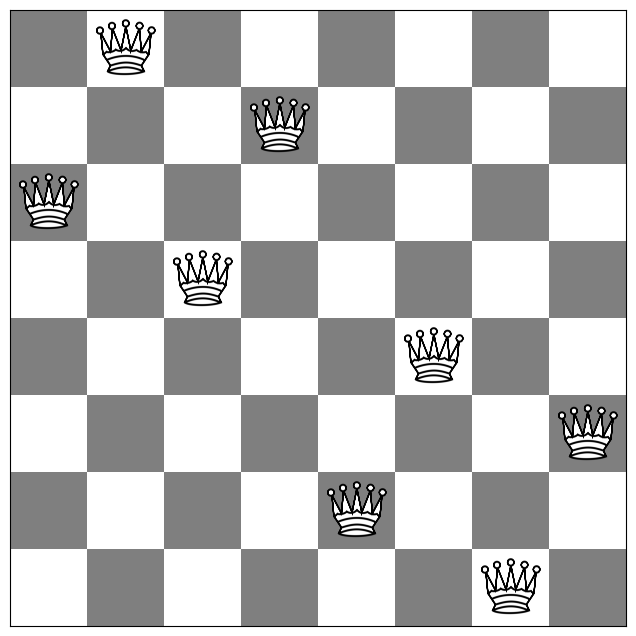

Solved Queen Placements:


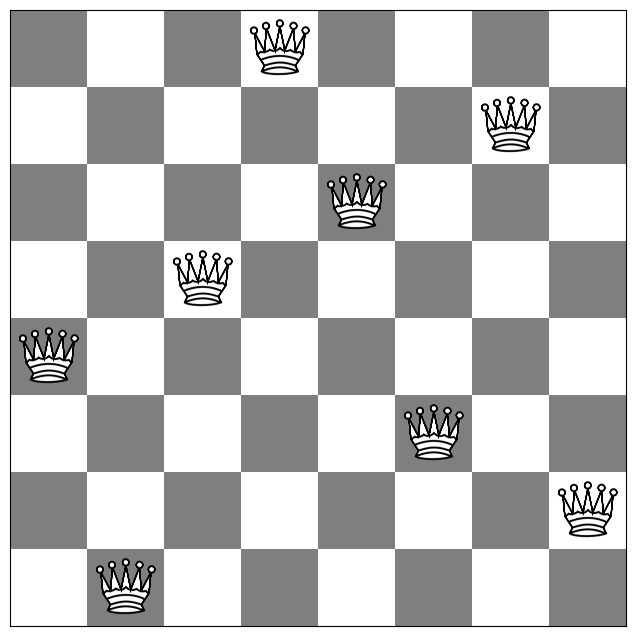

In [12]:
# Create initial placements for the queens
queen_list = []
for i in range(1, NUMBER_OF_QUEENS + 1):
    queen_list.append(Queen(i))

# Get initial placements
initial_placements = create_placements(queen_list)
initial_positions = [x.position for x in initial_placements]

# Plot initial placements
print("Initial Queen Placements:")
plot(initial_positions)

best_placement = genetic_algorithm(
    population=queen_list,
    pop_size=POP_SIZE,
    elite_size=ELITE_SIZE,
    mutation_rate=MUTATION_RATE,
    generations=GENERATIONS,
)

print("Solved Queen Placements:")
placements = [x.position for x in best_placement]
plot(placements)
